# N-Asset Efficient Frontier

In [3]:
%load_ext autoreload
%autoreload 2

import edhec_risk_kit as erk

In [4]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind.loc["1996":"2000"], 12)
cov = ind.loc["1996":"2000"].cov()

c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\edhec_risk_kit.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("ind30_m_rets.csv",


In [5]:
'''python
def plot_ef(n_points, er, cov, style = ".-"):
    """
    Plots the efficient frontier for a N-asset portfolio, with the number of points, expected returns, covariance matrix and plot style as inputs
    """
    weights = minimize_vol(target_return) # How do we do this?????
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame(
        {"Returns": rets, "Volatility": vols}
        )
    return ef.plot.line(x = "Volatility", y = "Returns", style = style)
'''

'python\ndef plot_ef(n_points, er, cov, style = ".-"):\n    """\n    Plots the efficient frontier for a N-asset portfolio, with the number of points, expected returns, covariance matrix and plot style as inputs\n    """\n    weights = minimize_vol(target_return) # How do we do this?????\n    rets = [portfolio_return(w, er) for w in weights]\n    vols = [portfolio_vol(w, cov) for w in weights]\n    ef = pd.DataFrame(\n        {"Returns": rets, "Volatility": vols}\n        )\n    return ef.plot.line(x = "Volatility", y = "Returns", style = style)\n'

In the above cell, figuring out the weights will be the tricky part, as we may have more than 2 assets, and we want to get the weights that would minimize volatility for a target return. How do we do this? This is where optimization comes in.

In [6]:
# we will use a quadratic optimizer that is built into scipy
from scipy.optimize import minimize

<Axes: xlabel='Volatility'>

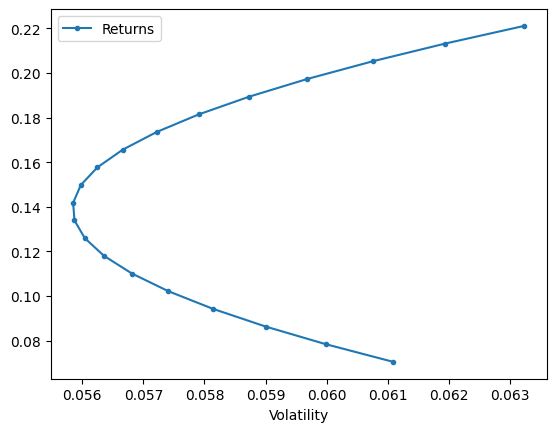

In [7]:
l = ["Games", "Fin"]
erk.plot_ef2(20, er[l], cov.loc[l,l], style=".-")

In [8]:
import numpy as np
'''
We might define a function like the following to check if the portfolio return equals the target return
def target_is_met(w, er):
    return target_return - erk.portfolio_return(w, er)
'''

def minimize_vol(target_return, er, cov):
    """
    target return --> weights
    """
    n = er.shape[0] # number of assets is the same as the number of rows in the expected returns array
    init_guess = np.repeat(1/n, n) #weights are inialized to be equal weights for all n assets
    bounds = ((0.0, 1.0),)*n  # specifies the bounds as an n-tuple of the lower (0%) and upper (100%) bounds for the weights
    return_is_target = {
        'type': 'eq', # equality constraint
        'args': (er,),
        'fun': lambda weights, er: target_return - erk.portfolio_return(weights, er) # lambda function that calculates on the fly if the portfolio return equals the target return
    }
    weights_sum_to_1 = {
        'type': 'eq', # equality constraint
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method="SLSQP", # quadratic programming optimizer
                       options={'disp': False},  # set display to false to avoid results cluttering the screen
                       constraints=(return_is_target, weights_sum_to_1), # set the constraints
                       bounds=bounds
                       )
    return results.x #passes the results to a variable called x

In [9]:
# now we will test the minimize_vol function on the 2 asset portfolio with assets "Games" and "Fin", for the eff portfolio that yields a 15% return. From the chart plotted above, it appears that the vol is around 5.6%
# target return = 0.15
w15 = minimize_vol(0.15, er[l], cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l]) # to check if we get the std dev we expect to see from these weights
vol15

0.05598188349002253

In [10]:
w15

array([0.4717977, 0.5282023])

That works! Now we will save the minimize_vol function to our module erk

In [11]:
w15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l]) # to check if we get the std dev we expect to see from these weights
vol15

0.05598188349002253

In [12]:
w15

array([0.4717977, 0.5282023])

Now we will extend the efficient frontier function to N assets

In [15]:
import pandas as pd

In [16]:
def optimal_weights(n_points, er, cov):
    """
    Generates a list of weights to run the optimizer on, to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points) # takes a number of returns that lie inbetween the minimum and maximum expected returns
    weights = [erk.minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov, style = ".-"):
    """
    Plots the efficient frontier for a N-asset portfolio, with the number of points, expected returns, covariance matrix and plot style as inputs
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [erk.portfolio_return(w, er) for w in weights]
    vols = [erk.portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame(
        {"Returns": rets, "Volatility": vols}
        )
    return ef.plot.line(x = "Volatility", y = "Returns", style = style)

<Axes: xlabel='Volatility'>

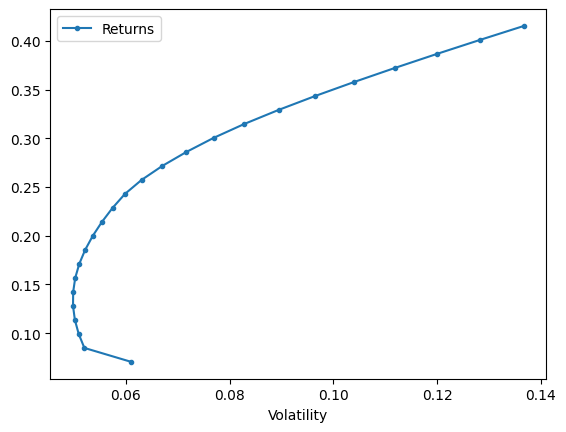

In [17]:
l = ["Smoke", "Fin", "Games","Coal"]
plot_ef(25, er[l], cov.loc[l,l], style=".-")

Add the above functions to the module erk

<Axes: xlabel='Volatility'>

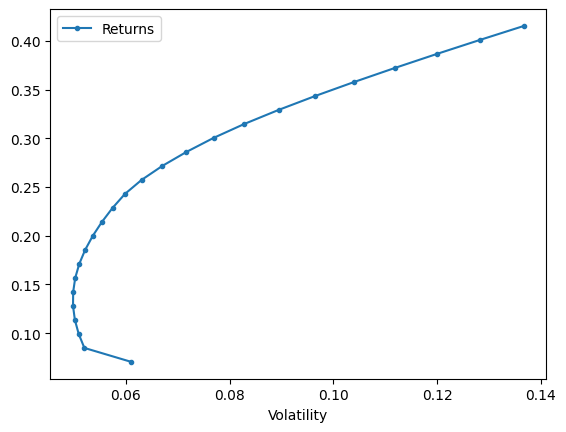

In [18]:
# trying out the function now:
l = ["Smoke", "Fin", "Games","Coal"]
erk.plot_ef(25, er[l], cov.loc[l,l], style=".-")
